In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import os.path as path
import itertools
from sklearn.preprocessing import maxabs_scale

In [2]:
import tensorflow.keras as keras
from tensorflow.keras.layers import Input, Dense, Activation, BatchNormalization, \
                                    Flatten, Conv1D, MaxPooling1D, Dropout, \
                                    Concatenate, GlobalMaxPool1D, GlobalAvgPool1D
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler, \
                                        EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '5'

In [4]:
base_dir = path.join('..', 'data')
data_dir = path.join(base_dir, 'data_speech_commands_v0.02')
 
train_txt = path.join(data_dir, 'wav_train_16words.txt')
val_txt = path.join(data_dir, 'wav_validation_16words.txt')
test_txt = path.join(data_dir, 'wav_test_16words.txt')

train_data = np.load(path.join(data_dir, 'wav_train_data.npz'))
val_data = np.load(path.join(data_dir, 'wav_validation_data.npz'))
test_data = np.load(path.join(data_dir, 'wav_test_data.npz'))

In [5]:
x_train = train_data['x_train']
y_train = train_data['y_train']
x_val = val_data['x_val']
y_val = val_data['y_val']
x_test = test_data['x_test']
y_test = test_data['y_test']
y_table = test_data['table']

x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape, y_table.shape

((36805, 16000, 1),
 (36805,),
 (4293, 16000, 1),
 (4293,),
 (4815, 16000, 1),
 (4815,),
 (16, 2))

In [6]:
input_shape = x_test[0].shape
output_size = y_table.shape[0]

In [7]:
x_train_abs = np.asarray([maxabs_scale(wav) for wav in x_train])
y_train_onehot = np.asarray([to_categorical(label, output_size) for label in y_train])
del x_train, y_train

x_val_abs = np.asarray([maxabs_scale(wav) for wav in x_val])
y_val_onehot = np.asarray([to_categorical(label, output_size) for label in y_val])
del x_val, y_val

x_test_abs = np.asarray([maxabs_scale(wav) for wav in x_test])
y_test_onehot = np.asarray([to_categorical(label, output_size) for label in y_test])
del x_test, y_test

In [8]:
def build_cnn(conv_num=1):
    filter_size = 64

    input_layer = Input(shape=input_shape)
    x = input_layer

    layer_outputs = []
    for i in range(conv_num):
        x = Conv1D (kernel_size=5, filters=filter_size*(2**(i//4)), 
                          strides=1, padding='same')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = MaxPooling1D(pool_size=3, strides=3)(x)
        layer_outputs.append(x)    
    
    x = Concatenate()([GlobalAvgPool1D()(output) for output in layer_outputs[-2:]])
    x = Dropout(0.5)(x)
    x = Dense(output_size, activation='softmax')(x)
    
    model = Model(inputs=input_layer, outputs=x)
    return model

In [9]:
for i in range(3, 9):
    model = build_cnn(conv_num=i)
    model.summary()
    del model

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 16000, 64)    384         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1 (BatchNo (None, 16000, 64)    256         conv1d[0][0]                     
__________________________________________________________________________________________________
activation (Activatio

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_7 (Conv1D)               (None, 16000, 64)    384         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1_7 (Batch (None, 16000, 64)    256         conv1d_7[0][0]                   
__________________________________________________________________________________________________
activation_7 (Activation)       (None, 16000, 64)    0           batch_normalization_v1_7[0][0]   
__________________________________________________________________________________________________
max_poolin

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_18 (Conv1D)              (None, 16000, 64)    384         input_5[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1_18 (Batc (None, 16000, 64)    256         conv1d_18[0][0]                  
__________________________________________________________________________________________________
activation_18 (Activation)      (None, 16000, 64)    0           batch_normalization_v1_18[0][0]  
__________________________________________________________________________________________________
max_poolin

Train on 36805 samples, validate on 4293 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.5546 - acc: 0.1880
Epoch 00001: val_loss improved from inf to 2.39308, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_DO_BN_3_conv_checkpoint/001-2.3931.hdf5
36805/36805 [==============================] - 54s 1ms/sample - loss: 2.5546 - acc: 0.1880 - val_loss: 2.3931 - val_acc: 0.3156
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.2497 - acc: 0.2824
Epoch 00002: val_loss improved from 2.39308 to 2.06287, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_DO_BN_3_conv_checkpoint/002-2.0629.hdf5
36805/36805 [==============================] - 52s 1ms/sample - loss: 2.2497 - acc: 0.2824 - val_loss: 2.0629 - val_acc: 0.4498
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.1332 - acc: 0.3171
Epoch 00003: val_loss improved from 2.06287 to 1.9545

Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.4116 - acc: 0.5585
Epoch 00024: val_loss improved from 1.27507 to 1.23886, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_DO_BN_3_conv_checkpoint/024-1.2389.hdf5
36805/36805 [==============================] - 52s 1ms/sample - loss: 1.4115 - acc: 0.5585 - val_loss: 1.2389 - val_acc: 0.6452
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.4069 - acc: 0.5604
Epoch 00025: val_loss did not improve from 1.23886
36805/36805 [==============================] - 52s 1ms/sample - loss: 1.4068 - acc: 0.5604 - val_loss: 1.2880 - val_acc: 0.6140
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.3937 - acc: 0.5668
Epoch 00026: val_loss improved from 1.23886 to 1.23629, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_DO_BN_3_conv_checkpoint/026-1.2363.hdf5
36805/36805 [==============================] - 52s 1ms/sample - loss: 1.3937 - acc: 0.5668 -

36800/36805 [============================>.] - ETA: 0s - loss: 1.2369 - acc: 0.6220
Epoch 00050: val_loss did not improve from 1.06704
36805/36805 [==============================] - 52s 1ms/sample - loss: 1.2371 - acc: 0.6219 - val_loss: 1.0702 - val_acc: 0.6937
Epoch 51/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.2267 - acc: 0.6219
Epoch 00051: val_loss improved from 1.06704 to 1.04694, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_DO_BN_3_conv_checkpoint/051-1.0469.hdf5
36805/36805 [==============================] - 52s 1ms/sample - loss: 1.2267 - acc: 0.6220 - val_loss: 1.0469 - val_acc: 0.6841
Epoch 52/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.2246 - acc: 0.6259
Epoch 00052: val_loss improved from 1.04694 to 1.03938, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_DO_BN_3_conv_checkpoint/052-1.0394.hdf5
36805/36805 [==============================] - 52s 1ms/sample - loss: 1.2247 - acc: 0.6258 - val_loss: 1.

36800/36805 [============================>.] - ETA: 0s - loss: 1.1395 - acc: 0.6530
Epoch 00077: val_loss did not improve from 0.97902
36805/36805 [==============================] - 52s 1ms/sample - loss: 1.1395 - acc: 0.6530 - val_loss: 0.9853 - val_acc: 0.7086
Epoch 78/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1352 - acc: 0.6519
Epoch 00078: val_loss did not improve from 0.97902
36805/36805 [==============================] - 52s 1ms/sample - loss: 1.1351 - acc: 0.6519 - val_loss: 1.2921 - val_acc: 0.5851
Epoch 79/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1316 - acc: 0.6538
Epoch 00079: val_loss did not improve from 0.97902
36805/36805 [==============================] - 52s 1ms/sample - loss: 1.1317 - acc: 0.6537 - val_loss: 1.3320 - val_acc: 0.5740
Epoch 80/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1310 - acc: 0.6544
Epoch 00080: val_loss improved from 0.97902 to 0.95205, saving model to model/checkpoint

Epoch 105/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.0779 - acc: 0.6702
Epoch 00105: val_loss did not improve from 0.89820
36805/36805 [==============================] - 52s 1ms/sample - loss: 1.0778 - acc: 0.6702 - val_loss: 0.9812 - val_acc: 0.6993
Epoch 106/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.0744 - acc: 0.6726
Epoch 00106: val_loss did not improve from 0.89820
36805/36805 [==============================] - 52s 1ms/sample - loss: 1.0744 - acc: 0.6726 - val_loss: 0.9551 - val_acc: 0.7151
Epoch 107/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.0706 - acc: 0.6736
Epoch 00107: val_loss did not improve from 0.89820
36805/36805 [==============================] - 52s 1ms/sample - loss: 1.0706 - acc: 0.6737 - val_loss: 0.9722 - val_acc: 0.6809
Epoch 108/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.0700 - acc: 0.6757
Epoch 00108: val_loss did not improve from 0.89820
36805/36805 [=======

36800/36805 [============================>.] - ETA: 0s - loss: 1.0344 - acc: 0.6839
Epoch 00134: val_loss did not improve from 0.85830
36805/36805 [==============================] - 52s 1ms/sample - loss: 1.0345 - acc: 0.6838 - val_loss: 1.4640 - val_acc: 0.5188
Epoch 135/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.0267 - acc: 0.6901
Epoch 00135: val_loss did not improve from 0.85830
36805/36805 [==============================] - 51s 1ms/sample - loss: 1.0266 - acc: 0.6902 - val_loss: 0.9244 - val_acc: 0.7193
Epoch 136/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.0245 - acc: 0.6899
Epoch 00136: val_loss did not improve from 0.85830
36805/36805 [==============================] - 51s 1ms/sample - loss: 1.0245 - acc: 0.6899 - val_loss: 0.9739 - val_acc: 0.6946
Epoch 137/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.0299 - acc: 0.6905
Epoch 00137: val_loss did not improve from 0.85830
36805/36805 [=====================

36800/36805 [============================>.] - ETA: 0s - loss: 0.9894 - acc: 0.7017
Epoch 00162: val_loss did not improve from 0.80538
36805/36805 [==============================] - 52s 1ms/sample - loss: 0.9895 - acc: 0.7017 - val_loss: 0.8905 - val_acc: 0.7349
Epoch 163/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9910 - acc: 0.7013
Epoch 00163: val_loss did not improve from 0.80538
36805/36805 [==============================] - 52s 1ms/sample - loss: 0.9914 - acc: 0.7012 - val_loss: 0.9426 - val_acc: 0.6960
Epoch 164/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9919 - acc: 0.6997
Epoch 00164: val_loss did not improve from 0.80538
36805/36805 [==============================] - 52s 1ms/sample - loss: 0.9919 - acc: 0.6997 - val_loss: 1.0573 - val_acc: 0.6597
Epoch 165/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9934 - acc: 0.6996
Epoch 00165: val_loss did not improve from 0.80538
36805/36805 [=====================

36800/36805 [============================>.] - ETA: 0s - loss: 0.9550 - acc: 0.7110
Epoch 00191: val_loss did not improve from 0.77527
36805/36805 [==============================] - 52s 1ms/sample - loss: 0.9550 - acc: 0.7110 - val_loss: 1.0310 - val_acc: 0.6515
Epoch 192/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9640 - acc: 0.7118
Epoch 00192: val_loss did not improve from 0.77527
36805/36805 [==============================] - 51s 1ms/sample - loss: 0.9640 - acc: 0.7118 - val_loss: 1.0816 - val_acc: 0.6382
Epoch 193/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9639 - acc: 0.7118
Epoch 00193: val_loss did not improve from 0.77527
36805/36805 [==============================] - 52s 1ms/sample - loss: 0.9639 - acc: 0.7118 - val_loss: 0.8551 - val_acc: 0.7512
Epoch 194/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9549 - acc: 0.7133
Epoch 00194: val_loss did not improve from 0.77527
36805/36805 [=====================

36800/36805 [============================>.] - ETA: 0s - loss: 0.9330 - acc: 0.7216
Epoch 00220: val_loss did not improve from 0.74413
36805/36805 [==============================] - 52s 1ms/sample - loss: 0.9330 - acc: 0.7216 - val_loss: 2.0416 - val_acc: 0.4370
Epoch 221/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9315 - acc: 0.7222
Epoch 00221: val_loss did not improve from 0.74413
36805/36805 [==============================] - 51s 1ms/sample - loss: 0.9315 - acc: 0.7222 - val_loss: 1.6117 - val_acc: 0.5225
Epoch 222/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9380 - acc: 0.7185
Epoch 00222: val_loss did not improve from 0.74413
36805/36805 [==============================] - 51s 1ms/sample - loss: 0.9381 - acc: 0.7185 - val_loss: 0.9344 - val_acc: 0.7058
Epoch 223/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9389 - acc: 0.7175
Epoch 00223: val_loss did not improve from 0.74413
36805/36805 [=====================

36800/36805 [============================>.] - ETA: 0s - loss: 0.9093 - acc: 0.7281
Epoch 00249: val_loss did not improve from 0.73128
36805/36805 [==============================] - 51s 1ms/sample - loss: 0.9093 - acc: 0.7281 - val_loss: 1.9769 - val_acc: 0.4614
Epoch 250/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9122 - acc: 0.7259
Epoch 00250: val_loss did not improve from 0.73128
36805/36805 [==============================] - 51s 1ms/sample - loss: 0.9121 - acc: 0.7259 - val_loss: 0.8816 - val_acc: 0.7251
Epoch 251/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9100 - acc: 0.7282
Epoch 00251: val_loss did not improve from 0.73128
36805/36805 [==============================] - 51s 1ms/sample - loss: 0.9100 - acc: 0.7282 - val_loss: 0.7473 - val_acc: 0.7864
Epoch 252/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9115 - acc: 0.7253
Epoch 00252: val_loss did not improve from 0.73128
36805/36805 [=====================

36800/36805 [============================>.] - ETA: 0s - loss: 0.8961 - acc: 0.7310
Epoch 00278: val_loss did not improve from 0.71386
36805/36805 [==============================] - 51s 1ms/sample - loss: 0.8961 - acc: 0.7310 - val_loss: 7.6137 - val_acc: 0.2364
Epoch 279/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8961 - acc: 0.7327
Epoch 00279: val_loss improved from 0.71386 to 0.71179, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_DO_BN_3_conv_checkpoint/279-0.7118.hdf5
36805/36805 [==============================] - 52s 1ms/sample - loss: 0.8960 - acc: 0.7327 - val_loss: 0.7118 - val_acc: 0.8046
Epoch 280/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8914 - acc: 0.7341
Epoch 00280: val_loss did not improve from 0.71179
36805/36805 [==============================] - 51s 1ms/sample - loss: 0.8913 - acc: 0.7342 - val_loss: 1.0650 - val_acc: 0.6657
Epoch 281/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.

Epoch 307/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8721 - acc: 0.7398
Epoch 00307: val_loss did not improve from 0.70467
36805/36805 [==============================] - 51s 1ms/sample - loss: 0.8721 - acc: 0.7398 - val_loss: 1.2786 - val_acc: 0.5924
Epoch 308/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8765 - acc: 0.7362
Epoch 00308: val_loss did not improve from 0.70467
36805/36805 [==============================] - 51s 1ms/sample - loss: 0.8765 - acc: 0.7362 - val_loss: 1.3013 - val_acc: 0.5931
Epoch 309/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8736 - acc: 0.7385
Epoch 00309: val_loss did not improve from 0.70467
36805/36805 [==============================] - 51s 1ms/sample - loss: 0.8736 - acc: 0.7385 - val_loss: 0.7832 - val_acc: 0.7605
Epoch 310/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8786 - acc: 0.7376
Epoch 00310: val_loss did not improve from 0.70467
36805/36805 [=======

Epoch 337/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8678 - acc: 0.7407
Epoch 00337: val_loss did not improve from 0.70467
36805/36805 [==============================] - 51s 1ms/sample - loss: 0.8680 - acc: 0.7406 - val_loss: 0.7661 - val_acc: 0.7922
Epoch 338/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8653 - acc: 0.7436
Epoch 00338: val_loss did not improve from 0.70467
36805/36805 [==============================] - 51s 1ms/sample - loss: 0.8652 - acc: 0.7436 - val_loss: 3.5177 - val_acc: 0.3692
Epoch 339/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8610 - acc: 0.7418
Epoch 00339: val_loss did not improve from 0.70467
36805/36805 [==============================] - 51s 1ms/sample - loss: 0.8610 - acc: 0.7418 - val_loss: 1.6695 - val_acc: 0.5271
Epoch 340/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8638 - acc: 0.7431
Epoch 00340: val_loss did not improve from 0.70467
36805/36805 [=======

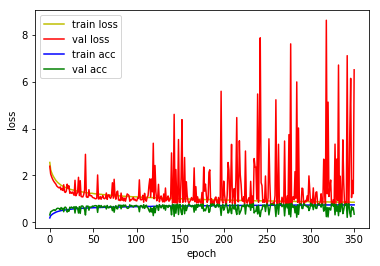

4815/4815 [==============================] - 3s 558us/sample - loss: 0.7707 - acc: 0.7778
Loss: 0.770710183526868 Accuracy: 0.7777778

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.4354 - acc: 0.2261
Epoch 00001: val_loss improved from inf to 2.24286, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_DO_BN_4_conv_checkpoint/001-2.2429.hdf5
36805/36805 [==============================] - 56s 2ms/sample - loss: 2.4353 - acc: 0.2262 - val_loss: 2.2429 - val_acc: 0.3743
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.0500 - acc: 0.3451
Epoch 00002: val_loss improved from 2.24286 to 1.78875, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_DO_BN_4_conv_checkpoint/002-1.7887.hdf5
36805/36805 [==============================] - 53s 1ms/sample - loss: 2.0500 - acc: 0.3451 - val_loss: 1.7887 - val_acc: 0.5302
Epoch 3/500
36800/36805 [============================>.] - ETA

Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.0426 - acc: 0.6862
Epoch 00025: val_loss did not improve from 0.88106
36805/36805 [==============================] - 53s 1ms/sample - loss: 1.0428 - acc: 0.6862 - val_loss: 1.2670 - val_acc: 0.5856
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.0193 - acc: 0.6976
Epoch 00026: val_loss improved from 0.88106 to 0.85400, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_DO_BN_4_conv_checkpoint/026-0.8540.hdf5
36805/36805 [==============================] - 53s 1ms/sample - loss: 1.0192 - acc: 0.6976 - val_loss: 0.8540 - val_acc: 0.7666
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.0184 - acc: 0.6920
Epoch 00027: val_loss improved from 0.85400 to 0.82911, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_DO_BN_4_conv_checkpoint/027-0.8291.hdf5
36805/36805 [==============================] - 53s 1ms/sample - loss: 1.0186 - acc: 0.6920 -

36800/36805 [============================>.] - ETA: 0s - loss: 0.8722 - acc: 0.7405
Epoch 00052: val_loss did not improve from 0.70235
36805/36805 [==============================] - 53s 1ms/sample - loss: 0.8724 - acc: 0.7404 - val_loss: 0.7136 - val_acc: 0.8064
Epoch 53/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8536 - acc: 0.7442
Epoch 00053: val_loss improved from 0.70235 to 0.67615, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_DO_BN_4_conv_checkpoint/053-0.6762.hdf5
36805/36805 [==============================] - 53s 1ms/sample - loss: 0.8538 - acc: 0.7441 - val_loss: 0.6762 - val_acc: 0.8223
Epoch 54/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8484 - acc: 0.7471
Epoch 00054: val_loss did not improve from 0.67615
36805/36805 [==============================] - 53s 1ms/sample - loss: 0.8485 - acc: 0.7470 - val_loss: 1.0637 - val_acc: 0.6532
Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.858

Epoch 80/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7775 - acc: 0.7670
Epoch 00080: val_loss did not improve from 0.60913
36805/36805 [==============================] - 52s 1ms/sample - loss: 0.7774 - acc: 0.7670 - val_loss: 2.3462 - val_acc: 0.4950
Epoch 81/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7749 - acc: 0.7689
Epoch 00081: val_loss did not improve from 0.60913
36805/36805 [==============================] - 52s 1ms/sample - loss: 0.7748 - acc: 0.7689 - val_loss: 1.0565 - val_acc: 0.6758
Epoch 82/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7696 - acc: 0.7717
Epoch 00082: val_loss did not improve from 0.60913
36805/36805 [==============================] - 52s 1ms/sample - loss: 0.7696 - acc: 0.7716 - val_loss: 2.6482 - val_acc: 0.4635
Epoch 83/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7679 - acc: 0.7710
Epoch 00083: val_loss did not improve from 0.60913
36805/36805 [===========

Epoch 109/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7198 - acc: 0.7868
Epoch 00109: val_loss did not improve from 0.57693
36805/36805 [==============================] - 53s 1ms/sample - loss: 0.7198 - acc: 0.7869 - val_loss: 0.6786 - val_acc: 0.8008
Epoch 110/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7146 - acc: 0.7890
Epoch 00110: val_loss did not improve from 0.57693
36805/36805 [==============================] - 53s 1ms/sample - loss: 0.7147 - acc: 0.7890 - val_loss: 0.5855 - val_acc: 0.8449
Epoch 111/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7245 - acc: 0.7844
Epoch 00111: val_loss did not improve from 0.57693
36805/36805 [==============================] - 53s 1ms/sample - loss: 0.7245 - acc: 0.7844 - val_loss: 0.6041 - val_acc: 0.8330
Epoch 112/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7187 - acc: 0.7863
Epoch 00112: val_loss did not improve from 0.57693
36805/36805 [=======

36800/36805 [============================>.] - ETA: 0s - loss: 0.6790 - acc: 0.7975
Epoch 00138: val_loss did not improve from 0.56615
36805/36805 [==============================] - 52s 1ms/sample - loss: 0.6789 - acc: 0.7975 - val_loss: 0.6433 - val_acc: 0.8043
Epoch 139/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.6777 - acc: 0.8001
Epoch 00139: val_loss improved from 0.56615 to 0.55072, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_DO_BN_4_conv_checkpoint/139-0.5507.hdf5
36805/36805 [==============================] - 52s 1ms/sample - loss: 0.6777 - acc: 0.8001 - val_loss: 0.5507 - val_acc: 0.8551
Epoch 140/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.6782 - acc: 0.7998
Epoch 00140: val_loss did not improve from 0.55072
36805/36805 [==============================] - 52s 1ms/sample - loss: 0.6784 - acc: 0.7997 - val_loss: 0.7510 - val_acc: 0.7668
Epoch 141/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.

Epoch 167/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.6449 - acc: 0.8092
Epoch 00167: val_loss did not improve from 0.52119
36805/36805 [==============================] - 52s 1ms/sample - loss: 0.6450 - acc: 0.8092 - val_loss: 1.6038 - val_acc: 0.6007
Epoch 168/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.6454 - acc: 0.8084
Epoch 00168: val_loss did not improve from 0.52119
36805/36805 [==============================] - 52s 1ms/sample - loss: 0.6455 - acc: 0.8084 - val_loss: 7.9138 - val_acc: 0.2662
Epoch 169/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.6460 - acc: 0.8096
Epoch 00169: val_loss did not improve from 0.52119
36805/36805 [==============================] - 52s 1ms/sample - loss: 0.6461 - acc: 0.8096 - val_loss: 0.6791 - val_acc: 0.8036
Epoch 170/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.6384 - acc: 0.8099
Epoch 00170: val_loss did not improve from 0.52119
36805/36805 [=======

36800/36805 [============================>.] - ETA: 0s - loss: 0.6194 - acc: 0.8145
Epoch 00196: val_loss did not improve from 0.51914
36805/36805 [==============================] - 52s 1ms/sample - loss: 0.6193 - acc: 0.8145 - val_loss: 0.5992 - val_acc: 0.8241
Epoch 197/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.6141 - acc: 0.8174
Epoch 00197: val_loss did not improve from 0.51914
36805/36805 [==============================] - 52s 1ms/sample - loss: 0.6141 - acc: 0.8174 - val_loss: 0.8747 - val_acc: 0.7354
Epoch 198/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.6127 - acc: 0.8164
Epoch 00198: val_loss did not improve from 0.51914
36805/36805 [==============================] - 52s 1ms/sample - loss: 0.6129 - acc: 0.8164 - val_loss: 0.6782 - val_acc: 0.8099
Epoch 199/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.6165 - acc: 0.8153
Epoch 00199: val_loss did not improve from 0.51914
36805/36805 [=====================

36800/36805 [============================>.] - ETA: 0s - loss: 0.5928 - acc: 0.8235
Epoch 00225: val_loss did not improve from 0.51666
36805/36805 [==============================] - 52s 1ms/sample - loss: 0.5928 - acc: 0.8235 - val_loss: 0.5959 - val_acc: 0.8297
Epoch 226/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5934 - acc: 0.8232
Epoch 00226: val_loss did not improve from 0.51666
36805/36805 [==============================] - 52s 1ms/sample - loss: 0.5936 - acc: 0.8232 - val_loss: 0.8569 - val_acc: 0.7419
Epoch 227/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5903 - acc: 0.8240
Epoch 00227: val_loss did not improve from 0.51666
36805/36805 [==============================] - 52s 1ms/sample - loss: 0.5904 - acc: 0.8240 - val_loss: 0.5307 - val_acc: 0.8528
Epoch 228/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5901 - acc: 0.8260
Epoch 00228: val_loss improved from 0.51666 to 0.49691, saving model to model/checkpo

36800/36805 [============================>.] - ETA: 0s - loss: 0.5677 - acc: 0.8299
Epoch 00254: val_loss did not improve from 0.49691
36805/36805 [==============================] - 52s 1ms/sample - loss: 0.5679 - acc: 0.8298 - val_loss: 4.8874 - val_acc: 0.3345
Epoch 255/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5714 - acc: 0.8294
Epoch 00255: val_loss did not improve from 0.49691
36805/36805 [==============================] - 52s 1ms/sample - loss: 0.5714 - acc: 0.8294 - val_loss: 1.7504 - val_acc: 0.5618
Epoch 256/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5672 - acc: 0.8318
Epoch 00256: val_loss did not improve from 0.49691
36805/36805 [==============================] - 52s 1ms/sample - loss: 0.5675 - acc: 0.8318 - val_loss: 0.6363 - val_acc: 0.8118
Epoch 257/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5745 - acc: 0.8286
Epoch 00257: val_loss did not improve from 0.49691
36805/36805 [=====================

36800/36805 [============================>.] - ETA: 0s - loss: 0.5483 - acc: 0.8328
Epoch 00283: val_loss did not improve from 0.48568
36805/36805 [==============================] - 52s 1ms/sample - loss: 0.5483 - acc: 0.8328 - val_loss: 1.0005 - val_acc: 0.7056
Epoch 284/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5454 - acc: 0.8383
Epoch 00284: val_loss did not improve from 0.48568
36805/36805 [==============================] - 52s 1ms/sample - loss: 0.5455 - acc: 0.8383 - val_loss: 0.4990 - val_acc: 0.8605
Epoch 285/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5491 - acc: 0.8358
Epoch 00285: val_loss did not improve from 0.48568
36805/36805 [==============================] - 52s 1ms/sample - loss: 0.5490 - acc: 0.8358 - val_loss: 0.6328 - val_acc: 0.8018
Epoch 286/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5502 - acc: 0.8326
Epoch 00286: val_loss did not improve from 0.48568
36805/36805 [=====================

36800/36805 [============================>.] - ETA: 0s - loss: 0.5316 - acc: 0.8403
Epoch 00312: val_loss did not improve from 0.48004
36805/36805 [==============================] - 52s 1ms/sample - loss: 0.5318 - acc: 0.8403 - val_loss: 0.5908 - val_acc: 0.8360
Epoch 313/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5333 - acc: 0.8410
Epoch 00313: val_loss did not improve from 0.48004
36805/36805 [==============================] - 52s 1ms/sample - loss: 0.5335 - acc: 0.8410 - val_loss: 1.4560 - val_acc: 0.6138
Epoch 314/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5371 - acc: 0.8382
Epoch 00314: val_loss did not improve from 0.48004
36805/36805 [==============================] - 52s 1ms/sample - loss: 0.5371 - acc: 0.8382 - val_loss: 0.6442 - val_acc: 0.8029
Epoch 315/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5291 - acc: 0.8408
Epoch 00315: val_loss did not improve from 0.48004
36805/36805 [=====================

Epoch 342/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5182 - acc: 0.8429
Epoch 00342: val_loss did not improve from 0.48004
36805/36805 [==============================] - 52s 1ms/sample - loss: 0.5183 - acc: 0.8428 - val_loss: 0.5563 - val_acc: 0.8402
Epoch 343/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5196 - acc: 0.8413
Epoch 00343: val_loss did not improve from 0.48004
36805/36805 [==============================] - 52s 1ms/sample - loss: 0.5199 - acc: 0.8413 - val_loss: 1.5155 - val_acc: 0.6431
Epoch 344/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5190 - acc: 0.8444
Epoch 00344: val_loss did not improve from 0.48004
36805/36805 [==============================] - 52s 1ms/sample - loss: 0.5190 - acc: 0.8444 - val_loss: 3.9507 - val_acc: 0.4321
Epoch 345/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5219 - acc: 0.8443
Epoch 00345: val_loss did not improve from 0.48004
36805/36805 [=======

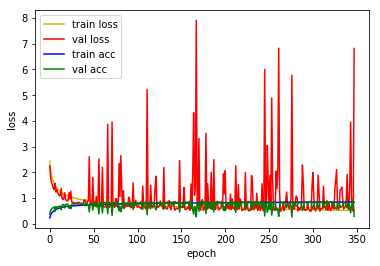

4815/4815 [==============================] - 3s 589us/sample - loss: 0.5613 - acc: 0.8401
Loss: 0.5612862356726626 Accuracy: 0.84008306

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.1931 - acc: 0.3042
Epoch 00001: val_loss improved from inf to 1.92370, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_DO_BN_5_conv_checkpoint/001-1.9237.hdf5
36805/36805 [==============================] - 58s 2ms/sample - loss: 2.1932 - acc: 0.3042 - val_loss: 1.9237 - val_acc: 0.4677
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.7062 - acc: 0.4648
Epoch 00002: val_loss improved from 1.92370 to 1.37213, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_DO_BN_5_conv_checkpoint/002-1.3721.hdf5
36805/36805 [==============================] - 54s 1ms/sample - loss: 1.7063 - acc: 0.4648 - val_loss: 1.3721 - val_acc: 0.6371
Epoch 3/500
36800/36805 [============================>.] - E

36800/36805 [============================>.] - ETA: 0s - loss: 0.6968 - acc: 0.7955
Epoch 00025: val_loss improved from 0.59061 to 0.57081, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_DO_BN_5_conv_checkpoint/025-0.5708.hdf5
36805/36805 [==============================] - 54s 1ms/sample - loss: 0.6969 - acc: 0.7954 - val_loss: 0.5708 - val_acc: 0.8463
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.6837 - acc: 0.8003
Epoch 00026: val_loss did not improve from 0.57081
36805/36805 [==============================] - 53s 1ms/sample - loss: 0.6837 - acc: 0.8003 - val_loss: 0.6258 - val_acc: 0.8244
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.6736 - acc: 0.8052
Epoch 00027: val_loss improved from 0.57081 to 0.55768, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_DO_BN_5_conv_checkpoint/027-0.5577.hdf5
36805/36805 [==============================] - 54s 1ms/sample - loss: 0.6738 - acc: 0.8051 - val_loss: 0.

Epoch 53/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5024 - acc: 0.8540
Epoch 00053: val_loss improved from 0.47152 to 0.45965, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_DO_BN_5_conv_checkpoint/053-0.4597.hdf5
36805/36805 [==============================] - 54s 1ms/sample - loss: 0.5027 - acc: 0.8539 - val_loss: 0.4597 - val_acc: 0.8705
Epoch 54/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5002 - acc: 0.8555
Epoch 00054: val_loss did not improve from 0.45965
36805/36805 [==============================] - 53s 1ms/sample - loss: 0.5002 - acc: 0.8555 - val_loss: 0.4774 - val_acc: 0.8744
Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4969 - acc: 0.8563
Epoch 00055: val_loss improved from 0.45965 to 0.42151, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_DO_BN_5_conv_checkpoint/055-0.4215.hdf5
36805/36805 [==============================] - 54s 1ms/sample - loss: 0.4969 - acc: 0.8563 -

36800/36805 [============================>.] - ETA: 0s - loss: 0.4016 - acc: 0.8835
Epoch 00081: val_loss did not improve from 0.36219
36805/36805 [==============================] - 53s 1ms/sample - loss: 0.4015 - acc: 0.8835 - val_loss: 0.3701 - val_acc: 0.8973
Epoch 82/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3972 - acc: 0.8837
Epoch 00082: val_loss did not improve from 0.36219
36805/36805 [==============================] - 53s 1ms/sample - loss: 0.3973 - acc: 0.8837 - val_loss: 0.3746 - val_acc: 0.9043
Epoch 83/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4009 - acc: 0.8820
Epoch 00083: val_loss did not improve from 0.36219
36805/36805 [==============================] - 53s 1ms/sample - loss: 0.4010 - acc: 0.8819 - val_loss: 0.5062 - val_acc: 0.8551
Epoch 84/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3902 - acc: 0.8856
Epoch 00084: val_loss did not improve from 0.36219
36805/36805 [========================

36800/36805 [============================>.] - ETA: 0s - loss: 0.3246 - acc: 0.9046
Epoch 00110: val_loss did not improve from 0.34737
36805/36805 [==============================] - 53s 1ms/sample - loss: 0.3246 - acc: 0.9046 - val_loss: 0.4241 - val_acc: 0.8933
Epoch 111/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3312 - acc: 0.9009
Epoch 00111: val_loss did not improve from 0.34737
36805/36805 [==============================] - 53s 1ms/sample - loss: 0.3312 - acc: 0.9008 - val_loss: 0.8324 - val_acc: 0.7645
Epoch 112/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3248 - acc: 0.9040
Epoch 00112: val_loss did not improve from 0.34737
36805/36805 [==============================] - 54s 1ms/sample - loss: 0.3249 - acc: 0.9040 - val_loss: 0.3712 - val_acc: 0.9050
Epoch 113/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3261 - acc: 0.9040
Epoch 00113: val_loss did not improve from 0.34737
36805/36805 [=====================

Epoch 139/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2798 - acc: 0.9157
Epoch 00139: val_loss did not improve from 0.32719
36805/36805 [==============================] - 54s 1ms/sample - loss: 0.2801 - acc: 0.9157 - val_loss: 0.3957 - val_acc: 0.8961
Epoch 140/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2837 - acc: 0.9135
Epoch 00140: val_loss did not improve from 0.32719
36805/36805 [==============================] - 53s 1ms/sample - loss: 0.2837 - acc: 0.9135 - val_loss: 0.3392 - val_acc: 0.9096
Epoch 141/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2769 - acc: 0.9186
Epoch 00141: val_loss did not improve from 0.32719
36805/36805 [==============================] - 53s 1ms/sample - loss: 0.2769 - acc: 0.9186 - val_loss: 0.4479 - val_acc: 0.8777
Epoch 142/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2714 - acc: 0.9186
Epoch 00142: val_loss did not improve from 0.32719
36805/36805 [=======

Epoch 168/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2445 - acc: 0.9254
Epoch 00168: val_loss did not improve from 0.32090
36805/36805 [==============================] - 53s 1ms/sample - loss: 0.2445 - acc: 0.9254 - val_loss: 0.4004 - val_acc: 0.8901
Epoch 169/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2410 - acc: 0.9256
Epoch 00169: val_loss did not improve from 0.32090
36805/36805 [==============================] - 54s 1ms/sample - loss: 0.2410 - acc: 0.9256 - val_loss: 0.4863 - val_acc: 0.8684
Epoch 170/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2392 - acc: 0.9291
Epoch 00170: val_loss did not improve from 0.32090
36805/36805 [==============================] - 53s 1ms/sample - loss: 0.2392 - acc: 0.9291 - val_loss: 0.3471 - val_acc: 0.9157
Epoch 171/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2416 - acc: 0.9283
Epoch 00171: val_loss did not improve from 0.32090
36805/36805 [=======

Epoch 198/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2188 - acc: 0.9326
Epoch 00198: val_loss improved from 0.32090 to 0.31598, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_DO_BN_5_conv_checkpoint/198-0.3160.hdf5
36805/36805 [==============================] - 53s 1ms/sample - loss: 0.2188 - acc: 0.9326 - val_loss: 0.3160 - val_acc: 0.9194
Epoch 199/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2111 - acc: 0.9357
Epoch 00199: val_loss did not improve from 0.31598
36805/36805 [==============================] - 53s 1ms/sample - loss: 0.2112 - acc: 0.9356 - val_loss: 0.7072 - val_acc: 0.8230
Epoch 200/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2168 - acc: 0.9339
Epoch 00200: val_loss did not improve from 0.31598
36805/36805 [==============================] - 53s 1ms/sample - loss: 0.2168 - acc: 0.9339 - val_loss: 0.3266 - val_acc: 0.9157
Epoch 201/500
36800/36805 [============================>.] - ETA:

36800/36805 [============================>.] - ETA: 0s - loss: 0.1901 - acc: 0.9419
Epoch 00227: val_loss did not improve from 0.31598
36805/36805 [==============================] - 53s 1ms/sample - loss: 0.1902 - acc: 0.9418 - val_loss: 0.3559 - val_acc: 0.9110
Epoch 228/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1915 - acc: 0.9430
Epoch 00228: val_loss did not improve from 0.31598
36805/36805 [==============================] - 53s 1ms/sample - loss: 0.1915 - acc: 0.9430 - val_loss: 0.4318 - val_acc: 0.8935
Epoch 229/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1838 - acc: 0.9446
Epoch 00229: val_loss did not improve from 0.31598
36805/36805 [==============================] - 53s 1ms/sample - loss: 0.1839 - acc: 0.9445 - val_loss: 0.4019 - val_acc: 0.9094
Epoch 230/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1871 - acc: 0.9434
Epoch 00230: val_loss did not improve from 0.31598
36805/36805 [=====================

36800/36805 [============================>.] - ETA: 0s - loss: 0.1672 - acc: 0.9487
Epoch 00256: val_loss did not improve from 0.30838
36805/36805 [==============================] - 53s 1ms/sample - loss: 0.1672 - acc: 0.9487 - val_loss: 0.3968 - val_acc: 0.9017
Epoch 257/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1697 - acc: 0.9483
Epoch 00257: val_loss did not improve from 0.30838
36805/36805 [==============================] - 53s 1ms/sample - loss: 0.1697 - acc: 0.9483 - val_loss: 0.3953 - val_acc: 0.9061
Epoch 258/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1685 - acc: 0.9485
Epoch 00258: val_loss did not improve from 0.30838
36805/36805 [==============================] - 53s 1ms/sample - loss: 0.1686 - acc: 0.9485 - val_loss: 0.3643 - val_acc: 0.9189
Epoch 259/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1682 - acc: 0.9482
Epoch 00259: val_loss did not improve from 0.30838
36805/36805 [=====================

Epoch 286/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1542 - acc: 0.9524
Epoch 00286: val_loss did not improve from 0.30838
36805/36805 [==============================] - 53s 1ms/sample - loss: 0.1542 - acc: 0.9524 - val_loss: 0.3966 - val_acc: 0.9008
Epoch 287/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1456 - acc: 0.9554
Epoch 00287: val_loss did not improve from 0.30838
36805/36805 [==============================] - 53s 1ms/sample - loss: 0.1456 - acc: 0.9554 - val_loss: 0.3298 - val_acc: 0.9166
Epoch 288/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1500 - acc: 0.9541
Epoch 00288: val_loss did not improve from 0.30838
36805/36805 [==============================] - 53s 1ms/sample - loss: 0.1508 - acc: 0.9540 - val_loss: 0.3534 - val_acc: 0.9122
Epoch 289/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1575 - acc: 0.9519
Epoch 00289: val_loss did not improve from 0.30838
36805/36805 [=======

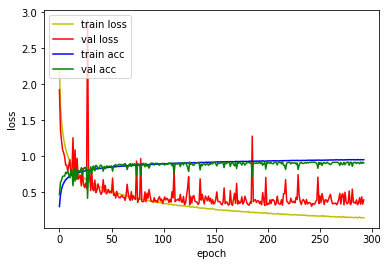

4815/4815 [==============================] - 3s 631us/sample - loss: 0.3849 - acc: 0.8914
Loss: 0.3848740494511209 Accuracy: 0.8913811

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.0035 - acc: 0.3674
Epoch 00001: val_loss improved from inf to 1.66865, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_DO_BN_6_conv_checkpoint/001-1.6686.hdf5
36805/36805 [==============================] - 64s 2ms/sample - loss: 2.0036 - acc: 0.3674 - val_loss: 1.6686 - val_acc: 0.5656
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.4070 - acc: 0.5724
Epoch 00002: val_loss improved from 1.66865 to 1.08677, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_DO_BN_6_conv_checkpoint/002-1.0868.hdf5
36805/36805 [==============================] - 57s 2ms/sample - loss: 1.4071 - acc: 0.5723 - val_loss: 1.0868 - val_acc: 0.7191
Epoch 3/500
36800/36805 [============================>.] - ET

36800/36805 [============================>.] - ETA: 0s - loss: 0.3264 - acc: 0.9079
Epoch 00025: val_loss improved from 0.28086 to 0.27834, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_DO_BN_6_conv_checkpoint/025-0.2783.hdf5
36805/36805 [==============================] - 55s 1ms/sample - loss: 0.3266 - acc: 0.9078 - val_loss: 0.2783 - val_acc: 0.9248
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3206 - acc: 0.9075
Epoch 00026: val_loss did not improve from 0.27834
36805/36805 [==============================] - 55s 1ms/sample - loss: 0.3206 - acc: 0.9075 - val_loss: 0.3172 - val_acc: 0.9143
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3106 - acc: 0.9104
Epoch 00027: val_loss did not improve from 0.27834
36805/36805 [==============================] - 55s 1ms/sample - loss: 0.3106 - acc: 0.9104 - val_loss: 0.2898 - val_acc: 0.9243
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.303

Epoch 53/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1846 - acc: 0.9455
Epoch 00053: val_loss did not improve from 0.20312
36805/36805 [==============================] - 55s 1ms/sample - loss: 0.1846 - acc: 0.9454 - val_loss: 0.2254 - val_acc: 0.9376
Epoch 54/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1857 - acc: 0.9440
Epoch 00054: val_loss did not improve from 0.20312
36805/36805 [==============================] - 55s 1ms/sample - loss: 0.1857 - acc: 0.9440 - val_loss: 0.2125 - val_acc: 0.9434
Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1831 - acc: 0.9458
Epoch 00055: val_loss did not improve from 0.20312
36805/36805 [==============================] - 55s 1ms/sample - loss: 0.1831 - acc: 0.9458 - val_loss: 0.2245 - val_acc: 0.9415
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1778 - acc: 0.9476
Epoch 00056: val_loss did not improve from 0.20312
36805/36805 [===========

36800/36805 [============================>.] - ETA: 0s - loss: 0.1206 - acc: 0.9635
Epoch 00082: val_loss did not improve from 0.20042
36805/36805 [==============================] - 55s 1ms/sample - loss: 0.1207 - acc: 0.9635 - val_loss: 0.2229 - val_acc: 0.9432
Epoch 83/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1245 - acc: 0.9627
Epoch 00083: val_loss improved from 0.20042 to 0.19877, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_DO_BN_6_conv_checkpoint/083-0.1988.hdf5
36805/36805 [==============================] - 55s 1ms/sample - loss: 0.1246 - acc: 0.9627 - val_loss: 0.1988 - val_acc: 0.9502
Epoch 84/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1172 - acc: 0.9648
Epoch 00084: val_loss did not improve from 0.19877
36805/36805 [==============================] - 55s 1ms/sample - loss: 0.1172 - acc: 0.9648 - val_loss: 0.2412 - val_acc: 0.9376
Epoch 85/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.121

36800/36805 [============================>.] - ETA: 0s - loss: 0.0862 - acc: 0.9734
Epoch 00111: val_loss did not improve from 0.19877
36805/36805 [==============================] - 55s 1ms/sample - loss: 0.0864 - acc: 0.9733 - val_loss: 0.2171 - val_acc: 0.9441
Epoch 112/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0922 - acc: 0.9712
Epoch 00112: val_loss did not improve from 0.19877
36805/36805 [==============================] - 55s 1ms/sample - loss: 0.0922 - acc: 0.9713 - val_loss: 0.2690 - val_acc: 0.9362
Epoch 113/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0834 - acc: 0.9749
Epoch 00113: val_loss did not improve from 0.19877
36805/36805 [==============================] - 55s 1ms/sample - loss: 0.0834 - acc: 0.9748 - val_loss: 0.2407 - val_acc: 0.9392
Epoch 114/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0837 - acc: 0.9748
Epoch 00114: val_loss did not improve from 0.19877
36805/36805 [=====================

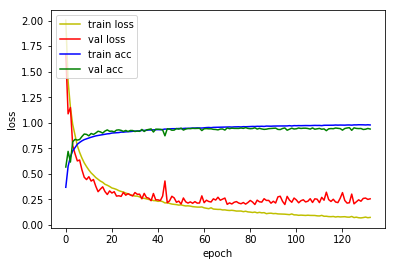

4815/4815 [==============================] - 3s 691us/sample - loss: 0.2411 - acc: 0.9354
Loss: 0.24108471978738177 Accuracy: 0.9354102

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.8063 - acc: 0.4338
Epoch 00001: val_loss improved from inf to 1.38310, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_DO_BN_7_conv_checkpoint/001-1.3831.hdf5
36805/36805 [==============================] - 68s 2ms/sample - loss: 1.8062 - acc: 0.4338 - val_loss: 1.3831 - val_acc: 0.6348
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.0183 - acc: 0.7051
Epoch 00002: val_loss improved from 1.38310 to 0.73132, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_DO_BN_7_conv_checkpoint/002-0.7313.hdf5
36805/36805 [==============================] - 56s 2ms/sample - loss: 1.0183 - acc: 0.7051 - val_loss: 0.7313 - val_acc: 0.8157
Epoch 3/500
36800/36805 [============================>.] - E

Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1421 - acc: 0.9591
Epoch 00025: val_loss did not improve from 0.15479
36805/36805 [==============================] - 56s 2ms/sample - loss: 0.1421 - acc: 0.9591 - val_loss: 0.1627 - val_acc: 0.9529
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1397 - acc: 0.9591
Epoch 00026: val_loss did not improve from 0.15479
36805/36805 [==============================] - 56s 2ms/sample - loss: 0.1398 - acc: 0.9591 - val_loss: 0.1739 - val_acc: 0.9485
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1362 - acc: 0.9599
Epoch 00027: val_loss did not improve from 0.15479
36805/36805 [==============================] - 56s 2ms/sample - loss: 0.1362 - acc: 0.9599 - val_loss: 0.1718 - val_acc: 0.9495
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1330 - acc: 0.9608
Epoch 00028: val_loss improved from 0.15479 to 0.14583, saving model to mod

36800/36805 [============================>.] - ETA: 0s - loss: 0.0584 - acc: 0.9823
Epoch 00053: val_loss did not improve from 0.13194
36805/36805 [==============================] - 56s 2ms/sample - loss: 0.0588 - acc: 0.9823 - val_loss: 0.1664 - val_acc: 0.9534
Epoch 54/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0671 - acc: 0.9795
Epoch 00054: val_loss did not improve from 0.13194
36805/36805 [==============================] - 56s 2ms/sample - loss: 0.0671 - acc: 0.9795 - val_loss: 0.2134 - val_acc: 0.9464
Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0540 - acc: 0.9849
Epoch 00055: val_loss did not improve from 0.13194
36805/36805 [==============================] - 56s 2ms/sample - loss: 0.0540 - acc: 0.9849 - val_loss: 0.1771 - val_acc: 0.9471
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0545 - acc: 0.9836
Epoch 00056: val_loss did not improve from 0.13194
36805/36805 [========================

Epoch 83/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0299 - acc: 0.9920
Epoch 00083: val_loss did not improve from 0.13194
36805/36805 [==============================] - 56s 2ms/sample - loss: 0.0299 - acc: 0.9920 - val_loss: 0.2339 - val_acc: 0.9450
Epoch 84/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0298 - acc: 0.9916
Epoch 00084: val_loss did not improve from 0.13194
36805/36805 [==============================] - 56s 2ms/sample - loss: 0.0299 - acc: 0.9916 - val_loss: 0.1714 - val_acc: 0.9606
Epoch 85/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0377 - acc: 0.9889
Epoch 00085: val_loss did not improve from 0.13194
36805/36805 [==============================] - 56s 2ms/sample - loss: 0.0377 - acc: 0.9889 - val_loss: 0.1547 - val_acc: 0.9606
Epoch 86/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0300 - acc: 0.9914
Epoch 00086: val_loss did not improve from 0.13194
36805/36805 [===========

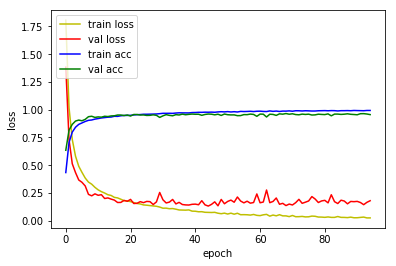

4815/4815 [==============================] - 3s 720us/sample - loss: 0.1709 - acc: 0.9495
Loss: 0.1709458163129949 Accuracy: 0.9495327

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.6653 - acc: 0.4864
Epoch 00001: val_loss improved from inf to 1.01852, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_DO_BN_8_conv_checkpoint/001-1.0185.hdf5
36805/36805 [==============================] - 74s 2ms/sample - loss: 1.6652 - acc: 0.4864 - val_loss: 1.0185 - val_acc: 0.7198
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7492 - acc: 0.7740
Epoch 00002: val_loss improved from 1.01852 to 0.47875, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_DO_BN_8_conv_checkpoint/002-0.4787.hdf5
36805/36805 [==============================] - 60s 2ms/sample - loss: 0.7493 - acc: 0.7739 - val_loss: 0.4787 - val_acc: 0.8633
Epoch 3/500
36800/36805 [============================>.] - ET

Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0786 - acc: 0.9771
Epoch 00025: val_loss improved from 0.12349 to 0.11583, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_DO_BN_8_conv_checkpoint/025-0.1158.hdf5
36805/36805 [==============================] - 58s 2ms/sample - loss: 0.0786 - acc: 0.9770 - val_loss: 0.1158 - val_acc: 0.9634
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0762 - acc: 0.9769
Epoch 00026: val_loss did not improve from 0.11583
36805/36805 [==============================] - 58s 2ms/sample - loss: 0.0762 - acc: 0.9769 - val_loss: 0.1372 - val_acc: 0.9571
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0637 - acc: 0.9820
Epoch 00027: val_loss did not improve from 0.11583
36805/36805 [==============================] - 58s 2ms/sample - loss: 0.0637 - acc: 0.9820 - val_loss: 0.1758 - val_acc: 0.9534
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s 

36800/36805 [============================>.] - ETA: 0s - loss: 0.0272 - acc: 0.9923
Epoch 00054: val_loss did not improve from 0.11583
36805/36805 [==============================] - 58s 2ms/sample - loss: 0.0272 - acc: 0.9923 - val_loss: 0.1737 - val_acc: 0.9576
Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0213 - acc: 0.9941
Epoch 00055: val_loss did not improve from 0.11583
36805/36805 [==============================] - 57s 2ms/sample - loss: 0.0213 - acc: 0.9941 - val_loss: 0.1384 - val_acc: 0.9641
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0259 - acc: 0.9924
Epoch 00056: val_loss did not improve from 0.11583
36805/36805 [==============================] - 58s 2ms/sample - loss: 0.0260 - acc: 0.9924 - val_loss: 0.1314 - val_acc: 0.9634
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0293 - acc: 0.9917
Epoch 00057: val_loss did not improve from 0.11583
36805/36805 [========================

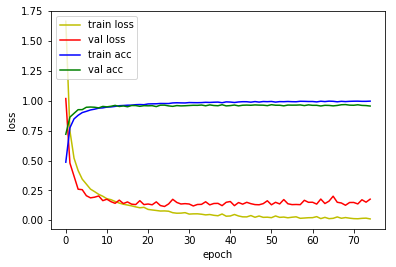

4815/4815 [==============================] - 4s 764us/sample - loss: 0.1592 - acc: 0.9522
Loss: 0.15922518963011625 Accuracy: 0.9522326



In [10]:
base = '1D_CNN_custom_multi_2_GAP_DO_BN'

for i in range(3, 9):
    model_name = base+'_{}_conv'.format(i)
    model = build_cnn(conv_num=i)
#         model.summary()
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4),
          metrics=['accuracy'])
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    os.makedirs(model_path, exist_ok=True)
    model_filename = model_path+'{epoch:03d}-{val_loss:.4f}.hdf5'
    checkpointer = ModelCheckpoint(filepath = model_filename, monitor = "val_loss", 
                                   verbose=1, save_best_only=True)

    early_stopping = EarlyStopping(monitor='val_loss', patience=50)
    hist = model.fit(x_train_abs, y_train_onehot, batch_size=64, epochs=500, 
                     validation_data=[x_val_abs, y_val_onehot], shuffle=True, 
                     callbacks = [checkpointer, early_stopping])

    print()
    print(model_name, 'Model')
    fig, ax = plt.subplots()
    ax.plot(hist.history['loss'], 'y', label='train loss')
    ax.plot(hist.history['val_loss'], 'r', label='val loss')
    ax.plot(hist.history['acc'], 'b', label='train acc')
    ax.plot(hist.history['val_acc'], 'g', label='val acc')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.legend(loc='upper left')
    plt.show()

    png_path = 'visualization/learning_curve/'
    filename = model_name+'.png'
    os.makedirs(png_path, exist_ok=True)
    fig.savefig(png_path+filename, transparent=True)

    model.save(model_path+'000_last.hdf5')
    del(model)
    
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
    model = load_model(model_filename)
    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)
    print()

    del(model)

In [11]:
log_dir = 'log'
os.makedirs(log_dir, exist_ok=True)
base = '1D_CNN_custom_multi_2_GAP_DO_BN'

with open(path.join(log_dir, base), 'w') as log_file:
    for i in range(3, 9):
        model_name = base+'_{}_conv'.format(i)
        print()
        print(model_name, 'Model')
        model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
        model_filename = model_path + sorted(os.listdir(model_path))[-1]

        model = load_model(model_filename)
        model.summary()

        [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
        print('Loss:', loss, 'Accuracy:', accuracy)

        del(model)

        log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


1D_CNN_custom_multi_2_GAP_DO_BN_3_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_33 (Conv1D)              (None, 16000, 64)    384         input_7[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1_33 (Batc (None, 16000, 64)    256         conv1d_33[0][0]                  
__________________________________________________________________________________________________
activation_33 (Activation)      (None, 16000, 64)    0           batch_normalization_v1_33[0][0]  
_______________________________________________________________

4815/4815 [==============================] - 4s 748us/sample - loss: 0.5613 - acc: 0.8401
Loss: 0.5612862356726626 Accuracy: 0.84008306

1D_CNN_custom_multi_2_GAP_DO_BN_5_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_40 (Conv1D)              (None, 16000, 64)    384         input_9[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1_40 (Batc (None, 16000, 64)    256         conv1d_40[0][0]                  
__________________________________________________________________________________________________
activation_40 (Activation)

4815/4815 [==============================] - 4s 821us/sample - loss: 0.2411 - acc: 0.9354
Loss: 0.24108471978738177 Accuracy: 0.9354102

1D_CNN_custom_multi_2_GAP_DO_BN_7_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_51 (Conv1D)              (None, 16000, 64)    384         input_11[0][0]                   
__________________________________________________________________________________________________
batch_normalization_v1_51 (Batc (None, 16000, 64)    256         conv1d_51[0][0]                  
__________________________________________________________________________________________________
activation_51 (Activation)

4815/4815 [==============================] - 4s 862us/sample - loss: 0.1592 - acc: 0.9522
Loss: 0.15922518963011625 Accuracy: 0.9522326


In [12]:
# log_dir = 'log'
# os.makedirs(log_dir, exist_ok=True)
# base = '1D_CNN_custom_DO_BN'

# with open(path.join(log_dir, base), 'w') as log_file:
for i in range(3, 9):
    model_name = base+'_{}_conv'.format(i)
    print()
    print(model_name, 'Model')
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + '000_last.hdf5'

    model = load_model(model_filename)
    model.summary()

    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)

    del(model)

#         log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


1D_CNN_custom_multi_2_GAP_DO_BN_3_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_33 (Conv1D)              (None, 16000, 64)    384         input_7[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1_33 (Batc (None, 16000, 64)    256         conv1d_33[0][0]                  
__________________________________________________________________________________________________
activation_33 (Activation)      (None, 16000, 64)    0           batch_normalization_v1_33[0][0]  
_______________________________________________________________

4815/4815 [==============================] - 4s 874us/sample - loss: 7.1073 - acc: 0.2663
Loss: 7.107347532868509 Accuracy: 0.2662513

1D_CNN_custom_multi_2_GAP_DO_BN_5_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_40 (Conv1D)              (None, 16000, 64)    384         input_9[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1_40 (Batc (None, 16000, 64)    256         conv1d_40[0][0]                  
__________________________________________________________________________________________________
activation_40 (Activation)  

4815/4815 [==============================] - 4s 920us/sample - loss: 0.3021 - acc: 0.9190
Loss: 0.3020774522426839 Accuracy: 0.9190031

1D_CNN_custom_multi_2_GAP_DO_BN_7_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_51 (Conv1D)              (None, 16000, 64)    384         input_11[0][0]                   
__________________________________________________________________________________________________
batch_normalization_v1_51 (Batc (None, 16000, 64)    256         conv1d_51[0][0]                  
__________________________________________________________________________________________________
activation_51 (Activation) 

4815/4815 [==============================] - 5s 959us/sample - loss: 0.2168 - acc: 0.9520
Loss: 0.2168404757305119 Accuracy: 0.95202494
